# Hands-on: Estátisticas de segunda ordem - LCR e AFD

### Objetivos
* Gerar um sinal no domínio do tempo a partir de um filtro de 3ª ordem;
* Encontrar LCR e AFD simulado;
* Calcular LCR e AFD teórico;
* Estimar frequência Doppler e velocidade;
* Encontrar o melhor $\rho$ para estimar frequência Doppler e velocidade.



## Parte 1: Gerar sinal no domínio do tempo

Vamos escrever um código para criação de um sinal sintético, para isso será necessário criar um filtro de terceira ordem, que represetará nosso canal.

**Passo 01:** Criar função **ThirdOrderFilter.m** que receberá como entrada a frequência Doppler e o tempo de amostragem. A função deve retornar o sinal de saída do filtro *Y_T* e tempo *t*.

In [46]:
%%file ThirdOrderFilter.m
function [Y_T, t] = ThirdOrderFilter(fd,ts)
%% Parameters
t=0:ts:1-ts;
zeta=0.175;                           % Underdamp  value for zeta
w0=2*pi*fd/1.2;                       % Natural angular frequency

%% Third order filter
% Coefficients
a=w0^3;
b=(2*zeta*w0)+w0;
c=(2*zeta*(w0^2))+(w0^2);

%% building third order Filter
syms f s w;                               % define symbols
tf_s=tf(a,[1 b c a]);                     % 3rd order tf in S domain
tf_z=c2d(tf_s,ts,'tustin');               % tustin: bilinear transformation

%% Impulse response of Digital Filter (channel)
[numZ, denZ, ts]=tfdata(tf_z,'v');
figure
[h] = impz(numZ,denZ);
%% find n0 : at this point h(n) become negligible
[pks,locs] = findpeaks(h);
nv=0.01;                  % negligible value  as a percentage of maximum value
b=find(pks>=(nv*max(pks)));
n0=max(locs(b));
%% normalizing the filter H(Z)
numZ_N=numZ./sqrt(sum(h.^2));      % normalize numerator of H(z)

%% Generating an input signal with unit power => (power_db = 0)
% Ip is vector (n0 ,1) , simulation time:T=0.1 sec
IP_no=(1/(sqrt(2))).*(randn(1,n0)+(1j*randn(1,n0)));
IP_T=(1/(sqrt(2))).*(randn(1,length(t))+(1j*randn(1,length(t))));
IP=[IP_no IP_T];                      % first n0 bits for transient response
% Output from filter
Y = filter(numZ_N,denZ,IP);              % output from filter
Y_T = Y(n0+1:end);                       % output after removing transients

Created file 'C:\Users\julie\OneDrive\Área de Trabalho\MESTRADO - PPGEEC\DISCIPLINAS\RADIOPROPAGAÇÃO\doppler\codigo_matlab\ThirdOrderFilter.m'.


**Passo 02:** Definir os parâmetros de entrada: 
* *fd*: frequência Doppler
* *ts*: tempo de amostragem 

E, então, realizar a chamada da função **ThirdOrderFilter.m** para obter o sinal gerado. Ao final, plote o sinal, em dB, no domínio do tempo.

Lembre-se que, ainda nessa simulação, vamos estimar o valor da frequência Doppler, então o valor de *fd* é importante para as conclusões finais.

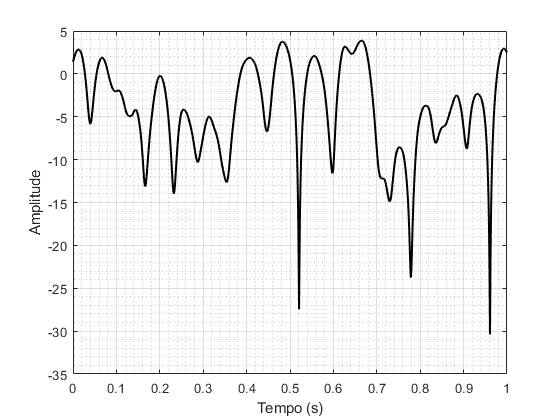

In [47]:
%% parâmetros
fd=10;                              % frequência Doppler (Hz)
ts=1e-6;                            % tempo de amostragem
fs=1/ts;                            % taxa de amostragem

[Y_T, t] = ThirdOrderFilter(fd,ts);

% Sinal em dB 
Y_T_db=20.*log10(abs(Y_T));        % output when length of input=T  in dB

%% plot do sinal no domínio do tempo
plot(t,Y_T_db,'k','LineWidth',1.5)
grid on
xlabel('Tempo (s)');
ylabel('Amplitude');
grid minor

## Parte 2: Encontrar LCR e AFD 

A caracterização do desvanecimento de pequena escala pode ser feita por estatística de segunda ordem. Duas importantes estatísticas são comumente utilizadas para caracterizar o efeito Doppler nos canais móveis. A primeira é a taxa de cruzamento do sinal (LCR - *Level Crossing Rate*) que corresponde a frequência em que a potência do sinal cruza um determinado liminar no sentido positivo. Já a segunda estatística é o tempo que o sinal permanece abaixo de um determinado limiar (AFD - *Average Fade Duration*) definido como o tempo médio que o sinal fica abaixo do limiar estabelecido. Veremos a seguir como é calculado essas duas métricas.

**Passo 01:** Para calcular LCR e AFD simulado, crie a função **CalculateLCRandAFD.m**. Essa função vai receber o vetor *x* correspondente ao sinal, o limiar *L* e o tempo de amostragem *ts*, retornando a taxa de cruzamento do sinal *LCR* e o o tempo médio que o sinal fica abaixo do limiar L estabelecido *AFD*.
1. Criar vetor *b* que será responsável por indicar os pontos abaixo do limiar *L*, sendo 1 quando *x* < *L*, e 0 para o contrário.
2. Criar o vetor *c* é responsável por contabilizar os cruzamentos. Inicialmente *c* = *b*, porém é feito uma varredura no sentido positivo que ao indentificar em *b* uma sequência de 1, entende que não há cruzamento e, portando, *c* naquele ponto passa a ser 0. Caso não seja identificado essa sequência, *c* permanece sendo 1, indicando o cruzamento.

In [55]:
%%file CalculateLCRandAFD.m
% this function takes four variables:- 
%    x: vector of real values
%    L: Level of crossing
%    ts: sampling time
% this function returns four variables:-
%    LCR  : Level Crossing Rate
%    AFD  : Average fade duration
function  [LCR AFD]= CalculateLCRandAFD(x,L,ts)
b=double((x<L));                
c=b;                            
for k=length(b):-1:2            
    if b(k)==1 & b(k-1)==1        
       c(k-1)=0;                
    end
end
CN_PD = sum(c);                  
LCR=CN_PD/(ts*length(x));
AFD=(sum(b)).*ts./CN_PD;

Created file 'C:\Users\julie\OneDrive\Área de Trabalho\MESTRADO - PPGEEC\DISCIPLINAS\RADIOPROPAGAÇÃO\doppler\codigo_matlab\CalculateLCRandAFD.m'.


**Passo 02:** O LCR e AFD depende da variável $\rho$ que se trata da Magnitude da Envoltória Complexa normalizada pelo RMS do sinal. Calcule o $\rho$ para cada amostra do sinal obtendo o vetor *xRho*, que será o limiar *L* de entrada para a função **CalculateLCRandAFD.m**. Sendo assim, chame a função para obter os valores de LCR simulado e AFD simulado para cada $\rho$.

**Passo 03:** Para calcular LCR teórico e AFD teórico, faremos a aplicação das fórmulas teóricas.
1. É importante saber que as fórmulas teóricas de LCR e AFD mudam em função de modelos clássicos de canais sem fio (Rayleigh, Rice, Nakagami e Weibull). No nosso caso, vamos seguir a modelo de Rayleigh, que é dado por: 

<center> $LCR_{Rayleigh} = \sqrt{2\pi}.f_d.\rho.\exp(-\rho^2)$</center>
<center> $AFD_{Rayleigh} = \frac{\exp(\rho^2)-1}{\sqrt{2\pi}.f_d.\rho}$</center>

2. Como as equações estão em função não só do $\rho$, mas também da frequência Doppler $f_d$, vamos normalizar as equações por $f_d$. Dessa forma, assim como o LCR simulado e AFD simulado, conseguimos deixar as equações apenas em função de $\rho$. Além disso, esse passo facilitará a estimação da frequência Doppler mais a seguir. Então:

<center> $ LCR_{Rayleigh_{norm}} = \frac{LCR_{Rayleigh}}{f_d} = \sqrt{2\pi}.\rho.\exp(-\rho^2)$ </center>
<center> $ AFD_{Rayleigh_{norm}} = \frac{f_d}{AFD_{Rayleigh}} = \frac{\exp(\rho^2)-1}{\sqrt{2\pi}.\rho}$ </center>


**Passo 04:** Plote dois gráficos: um com as curvas do AFD simulado e teórico em função do nível do sinal em dB/RMS e outro com as curvas do LCR simulado e teórico em função do nível do sinal em dB/RMS.

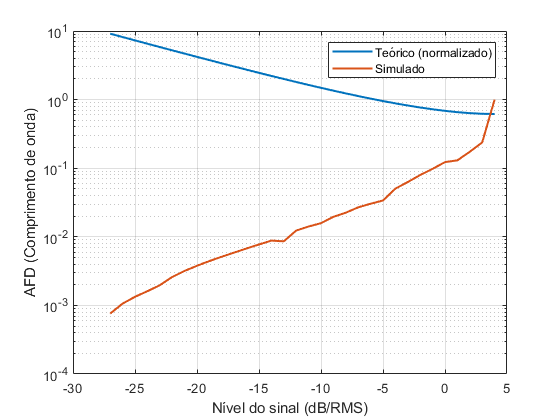

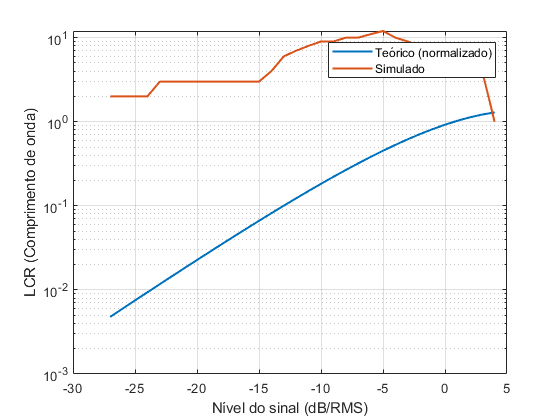

In [56]:
% cálculo do RMS (Root Mean Square) do sinal
rms_Y_T=rms(abs(Y_T));                  % rms of output length = T

% cálculo da magnitude da envoltória complexa normalizada por RMS
Rho = abs(Y_T)/rms_Y_T;
Rho_db=20*log10(Rho);
xRho = ceil(min(Rho_db))+1:floor(max(Rho_db))-1;

% cálculo do LCR e AFD simulado
for k=1:length(xRho)
    [LCR(k) AFD(k)]= CalculateLCRandAFD(Y_T_db,xRho(k),ts);
end

% cálculo do LCR e AFD teórico normalizado
LCRt_norm=(sqrt(2*pi).*(10.^(xRho./10)).*exp(-10.^(xRho./20)));
AFDt_norm=(exp(10.^(xRho./20))-1)./((sqrt(2*pi)).*(10.^(xRho./10)));

%% plot AFD simulado e teórico
figure,semilogy(xRho,AFDt_norm,xRho,AFD,'LineWidth',1.5);
xlabel('Nível do sinal (dB/RMS)') 
ylabel('AFD (Comprimento de onda)') 
legend('Teórico (normalizado)','Simulado')
grid on
%
%% plot LCR simulado e teórico
figure,semilogy(xRho,LCRt_norm,xRho,LCR,'LineWidth',1.5)
xlabel('Nível do sinal (dB/RMS)') 
ylabel('LCR (Comprimento de onda)')
legend('Teórico (normalizado)','Simulado')
grid on
%

## Parte 3: Estimação da frequência Doppler e velocidade

**Passo 01:** Realize a estimação da frequência Doppler, através do LCR e do AFD, e plote as curvas em um mesmo gráfico, em função do nível do sinal em dB/RMS.
1. Observe que, para o LCR, $ \hat{f}_d = \frac{LCR_{simulado}}{LCR_{teórico_{norm}}}$ 
2. De forma análoga, para o AFD, temos que $ \hat{f}_d = \frac{AFD_{teórico_{norm}}}{AFD_{simulado}}$ 

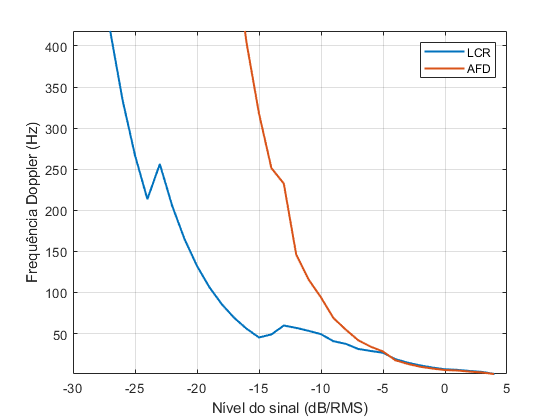

In [57]:
%% cálculo da frequência Doppler estimada
fd_lcr = LCR./LCRt_norm;
fd_afd = AFDt_norm./AFD;
%
%% plot
figure,plot(xRho,fd_lcr,xRho,fd_afd,'LineWidth',1.5)
xlabel('Nível do sinal (dB/RMS)')
ylabel('Frequência Doppler (Hz)')
legend('LCR','AFD')
grid on
ylim([min(fd_lcr) max(fd_lcr)])

**Passo 2:** De acordo com o resultado acima e assumindo que $f_d$ foi definido com 10 Hz, identifique o melhor nível $\rho$ a partir do LCR e do AFD. Plote dois gráficos:

* Um gráfico da Frequência Doppler vs do nível do sinal em dB/RMS, destacando o melhor $\rho$ para LCR e AFD;
* Um gráfico do nível do sinal em dB/RMS vs tempo destacando o melhor nível $\rho$ para LCR e AFD.

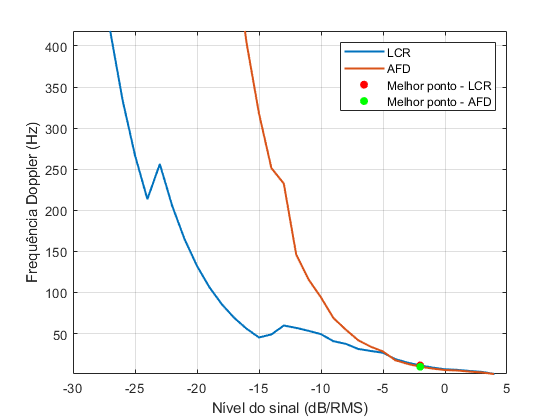

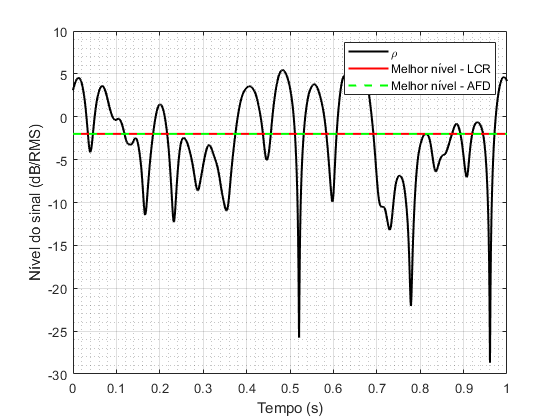

In [58]:
%% cálculo do melhor nível
% erro relativo
fd_erro_lcr = abs(fd_lcr - fd)/fd;
fd_erro_afd = abs(fd_afd - fd)/fd;
% encontra menor erro relativo
fd_idxbestRho_lcr=find(fd_erro_lcr==min(fd_erro_lcr));
fd_idxbestRho_afd=find(fd_erro_afd==min(fd_erro_afd));
fd_bestRho_lcr=fd_lcr(fd_idxbestRho_lcr);
fd_bestRho_afd=fd_afd(fd_idxbestRho_afd);
%
%% plots
figure,plot(xRho,fd_lcr,xRho,fd_afd,'LineWidth',1.5)
xlabel('Nível do sinal (dB/RMS)')
ylabel('Frequência Doppler (Hz)')
grid on
ylim([min(fd_lcr) max(fd_lcr)])
hold on
scatter(xRho(fd_idxbestRho_lcr),fd_bestRho_lcr,'filled','r','linewidth',1.5)
scatter(xRho(fd_idxbestRho_afd),fd_bestRho_afd,'filled','g','linewidth',1)
legend('LCR','AFD','Melhor ponto - LCR', 'Melhor ponto - AFD')
%
figure,plot(t,Rho_db,'k','LineWidth',1.5)
grid on
xlabel('Tempo (s)');
ylabel('Nível do sinal (dB/RMS)');
hold on
plot([t(1) t(end)],[xRho(fd_idxbestRho_lcr) xRho(fd_idxbestRho_lcr)],'-r','linewidth',1.5)
plot([t(1) t(end)],[xRho(fd_idxbestRho_afd) xRho(fd_idxbestRho_afd)],'--green','linewidth',1.5)
legend('\rho','Melhor nível - LCR','Melhor nível - AFD')
grid minor
hold off

**Passo 03:** Agora estime a velocidade, através do LCR e do AFD, e plote as curvas em um mesmo gráfico, em função do nível do sinal em dB/RMS. Veja que com $\hat{f}_d$, podemos calcular a velocidade estimada através de $ \hat{v} = \hat{f}_d.\lambda$.

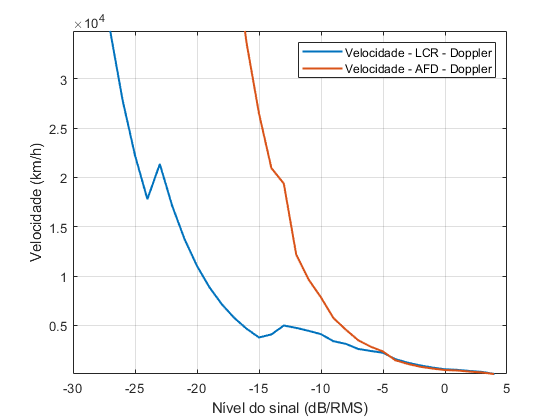

In [59]:
%% cálculo da velocidade estimada
c = 3*10^8;                      % velocidade da luz
lambda = c/fs;                   % comprimento de onda
v_lcr = fd_lcr*lambda/3.6;
v_afd = fd_afd*lambda/3.6;
%
%% plots
figure,plot(xRho,v_lcr,xRho,v_afd,'LineWidth',1.5)
xlabel('Nível do sinal (dB/RMS)')
ylabel('Velocidade (km/h)')
legend('LCR','AFD')
grid on
ylim([min(v_lcr) max(v_lcr)])

**Passo 04:** Vamos encontrar o melhor %\rho% para a velocidade. Esses pontos devem coincidir com os já encontrados através da frequência Doppler. 

1. Observe que a partir da equação descrita no **Passo 03**, podemos calcular também a velocidade teórica, assumindo que $f_d = 10$ Hz e $c$ é a velocidade da luz, equivalente a $3.10^{8}$ m/s. Observe:

<center>$ \hat{v} = f_d.\lambda = \frac{f_d . c}{f} $</center>

2. De acordo com a equação acima, calcule a velocidade teórica e identifique o melhor nível $\rho$ a partir do LCR e do AFD. Plote dois gráficos:

    * Um gráfico da Frequência Doppler vs do nível do sinal em dB/RMS, destacando o melhor $\rho$ para LCR e AFD;
    * Um gráfico do nível do sinal em dB/RMS vs tempo destacando o melhor nível $\rho$ para LCR e AFD.

A velocidade teórica, em km/h, é: 

v_teo =

  833.3333




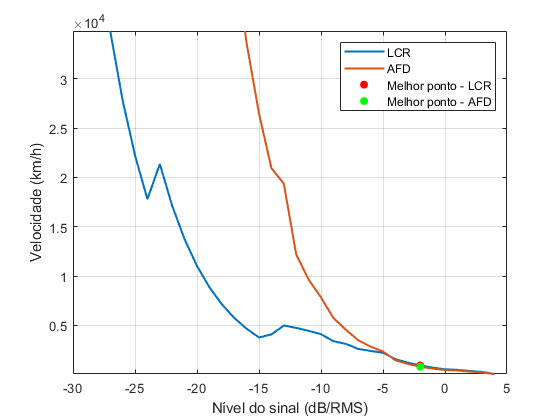

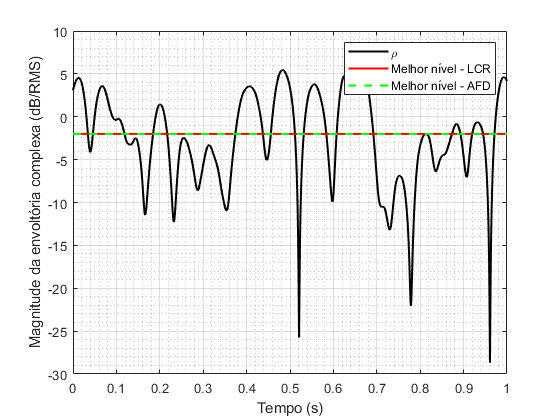

In [63]:
%% cálculo da velocidade teórica
v_teo = fd*lambda/3.6;
disp('A velocidade teórica, em km/h, é: ')
v_teo
%
%% cálculo do melhor nível
% erro relativo
v_erro_lcr = abs(v_lcr - v_teo)/v_teo;
v_erro_afd = abs(v_afd - v_teo)/v_teo;
% encontra menor erro relativo
v_idxbestRho_lcr=find(v_erro_lcr==min(v_erro_lcr));
v_idxbestRho_afd=find(v_erro_afd==min(v_erro_afd));
v_bestRho_lcr=v_lcr(v_idxbestRho_lcr);
v_bestRho_afd=v_afd(v_idxbestRho_afd);
%
%% plots
figure,plot(xRho,v_lcr,xRho,v_afd,'LineWidth',1.5)
xlabel('Nível do sinal (dB/RMS)')
ylabel('Velocidade (km/h)')
grid on
ylim([min(v_lcr) max(v_lcr)])
hold on
scatter(xRho(v_idxbestRho_lcr),v_bestRho_lcr,'filled','r')
scatter(xRho(v_idxbestRho_afd),v_bestRho_afd,'filled','g')
legend('LCR','AFD','Melhor ponto - LCR', 'Melhor ponto - AFD')
%
figure,plot(t,Rho_db,'k','LineWidth',1.5)
grid on
xlabel('Tempo (s)');
ylabel('Magnitude da envoltória complexa (dB/RMS)');
hold on
plot([t(1) t(end)],[xRho(v_idxbestRho_lcr) xRho(v_idxbestRho_lcr)],'-r','linewidth',1.5)
plot([t(1) t(end)],[xRho(v_idxbestRho_afd) xRho(v_idxbestRho_afd)],'--green','linewidth',1.5)
legend('\rho','Melhor nível - LCR','Melhor nível - AFD')
grid minor

### Referências

* MOHAMMED ELAMASSIE (2022). Level crossing rate (LCR) and average fade duration (AFD). Disponível em: https://www.mathworks.com/matlabcentral/fileexchange/54750-level-crossing-rate-lcr-and-average-fade-duration-afd. MATLAB Central File Exchange.
* ABDI, Ali, et al. Comparison of the level crossing rate and average fade duration of Rayleigh, Rice and Nakagami fading models with mobile channel data. In: Vehicular Technology Conference Fall 2000. IEEE VTS Fall VTC2000. 52nd Vehicular Technology Conference (Cat. No. 00CH37152). IEEE, 2000. p. 1850-1857

#### Leitura complementar: AFD e LCR para os demais modelos
* FRAIDENRAICH, Gustavo; YACOUB, Michel D.; SANTOS FILHO, José Cândido S. Second-order statistics of maximal-ratio and equal-gain combining in Weibull fading. IEEE communications letters, 2005, 9.6: 499-501.
* YACOUB, Michel Daoud; DA SILVA, Cláudio Rafael Cunha Monteiro; BAUTISTA, JE Vargas. Second-order statistics for diversity-combining techniques in Nakagami-fading channels. IEEE Transactions on Vehicular Technology, 2001, 50.6: 1464-1470.
* RICE, Stephen O. Mathematical analysis of random noise. The Bell System Technical Journal, 1944, 23.3: 282-332.